## Extension of the 5% pool for all tracers

In [1]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import numpy as np
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

import matplotlib.gridspec as gspec

import warnings
warnings.filterwarnings("ignore")

In [19]:
sns.set_context('notebook')
sns.set_style('white')

In [3]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF_7Tr/run01/gridGlob.nc'

grid_fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF_7Tr/run02/gridGlob.nc'

state_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF_7Tr/run01/stateGlob.nc' 

ptracers_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF_7Tr/run01/ptracersGlob.nc'

ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF_7Tr/run02/ptracersGlob.nc'

In [4]:
with Dataset(grid_file, 'r') as nbl:
    Z = nbl.variables['RC'][:]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
    hFacC = nbl.variables['HFacC'][:]
    rA = nbl.variables['rA'][:]
    Depth = nbl.variables['Depth'][:]

hfac = np.ma.masked_values(hFacC, 0)
maskC = np.ma.getmask(hfac)

with Dataset(grid_fileNoC, 'r') as nbl:
    hFacCNoC = nbl.variables['HFacC'][:]

hfac = np.ma.masked_values(hFacCNoC, 0)
maskCNoC = np.ma.getmask(hfac)
 

with Dataset(state_file, 'r') as nbl:
    iters = nbl.variables['iter'][:]
 

In [5]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def ConcAreaPool(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            if TrBottom > 0.0:
                ConcArea[i,j] = TrBottom*ra[i,j]
                Conc[i,j] = TrBottom
                Area[i,j] = ra[i,j]
            else:
                ConcArea[i,j] = np.NaN
                Conc[i,j] = np.NaN
                Area[i,j] = np.NaN
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def BottomConc(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def PlotPool(ax,ConcFilt,xslice,yslice,col):
    
    BAC = ConcFilt[yslice,xslice]
    
    mesh = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[0.05], 
                      colors=col, 
                      )
    
    
    mesh = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[-0.05], 
                      colors=col, 
                      )
    
    SB = ax.contour(X[xslice]/1000,Y[yslice]/1000,
                    Depth[yslice,xslice],
                    [150.0],
                    colors='0.1',linewidths=[0.75] )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    
def PlotAS(ax,Conc,xslice,zslice,col):
    
    mesh = ax.contour(X[xslice]/1000,Z[zslice],Conc,[0.05], 
                      colors=col, 
                      )
    mesh = ax.contour(X[xslice]/1000,Z[zslice],Conc,[-0.05], 
                      colors=col, 
                      )
    
    ax.plot(X[xslice]/1000,-Depth[yind_AS,xslice],
           '-',
           color='0.5',
           linewidth=2,
           )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    
def PlotCS(ax,Conc,yslice,zslice,col):
    
    mesh = ax.contour(Y[yslice]/1000,Z[zslice],Conc,[0.05], 
                      colors=col, 
                      )
    mesh = ax.contour(Y[yslice]/1000,Z[zslice],Conc,[-0.05], 
                      colors=col, 
                      )
    
    ax.plot(Y[yslice]/1000,-Depth[yslice_CS, xind_CS],
           '-',
           color='0.5',
           linewidth=2,
           )
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
        
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)

In [11]:
# General input
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 
yind_AS = 267
xind_CS = 240

xslice_AS = slice(120,500)
yslice_CS = slice(227,360)
zslice_AS = slice(0,30)

yslice = slice(225,360)
xslice = slice(120,500)

tracer_names = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
colours = ['dark lavender','ocean blue','kelly green','cherry red','tangerine','medium pink','turquoise']


In [7]:
ConcFilt1 = np.ma.empty((360,616)) 
ConcFilt2 = np.ma.empty((360,616))
ConcFilt3 = np.ma.empty((360,616))
ConcFilt4 = np.ma.empty((360,616))
ConcFilt5 = np.ma.empty((360,616))
ConcFilt6 = np.ma.empty((360,616))
ConcFilt7 = np.ma.empty((360,616))

ConcAS1 = np.ma.empty((30,len(X[xslice_AS]))) 
ConcAS2 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS3 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS4 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS5 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS6 = np.ma.empty((30,len(X[xslice_AS])))
ConcAS7 = np.ma.empty((30,len(X[xslice_AS])))


In [12]:
ConcCS1 = np.ma.empty((30,len(Y[yslice_CS]))) 
ConcCS2 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS3 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS4 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS5 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS6 = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS7 = np.ma.empty((30,len(Y[yslice_CS])))

concList = [ConcFilt1,ConcFilt2,ConcFilt3,ConcFilt4,ConcFilt5,ConcFilt6,ConcFilt7]
concASList = [ConcAS1,ConcAS2,ConcAS3,ConcAS4,ConcAS5,ConcAS6,ConcAS7]
concCSList = [ConcCS1,ConcCS2,ConcCS3,ConcCS4,ConcCS5,ConcCS6,ConcCS7]

for trac,conc, concAS, concCS in zip(tracer_names, concList, concASList, concCSList):
    with Dataset(ptracers_file, 'r') as nbl:
        ConcArea, conc[:,:], Area = BottomConc(np.mean(nbl.variables[trac][8:18,:,:,:], axis=0),hFacC,rA,Depth)
        concAS[:,:] = np.ma.array(np.nanmean(nbl.variables[trac][8:18,zslice_AS,yind_AS,xslice_AS],0),
                                  mask=maskCNoC[zslice_AS,yind_AS,xslice_AS])
        concCS[:,:] = np.ma.array(np.nanmean(nbl.variables[trac][8:18,zslice_AS,yslice_CS,xind_CS],0),
                                  mask=maskCNoC[zslice_AS,yslice_CS,xind_CS])
       
    print('done with tracer %s' %trac )

done with tracer Tr1
done with tracer Tr2
done with tracer Tr3
done with tracer Tr4
done with tracer Tr5
done with tracer Tr6
done with tracer Tr7


In [13]:
Conc0Filt1 = np.ma.empty((360,616)) # saving 3 time outputs, nx,ny
Conc0Filt2 = np.ma.empty((360,616))
Conc0Filt3 = np.ma.empty((360,616))
Conc0Filt4 = np.ma.empty((360,616))
Conc0Filt5 = np.ma.empty((360,616))
Conc0Filt6 = np.ma.empty((360,616))
Conc0Filt7 = np.ma.empty((360,616))

Conc0AS1 = np.ma.empty((30,len(X[xslice_AS]))) 
Conc0AS2 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS3 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS4 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS5 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS6 = np.ma.empty((30,len(X[xslice_AS])))
Conc0AS7 = np.ma.empty((30,len(X[xslice_AS])))


In [14]:
Conc0CS1 = np.ma.empty((30,len(Y[yslice_CS]))) 
Conc0CS2 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS3 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS4 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS5 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS6 = np.ma.empty((30,len(Y[yslice_CS])))
Conc0CS7 = np.ma.empty((30,len(Y[yslice_CS])))

concList = [Conc0Filt1,Conc0Filt2,Conc0Filt3,Conc0Filt4,Conc0Filt5,Conc0Filt6,Conc0Filt7]
concASList = [Conc0AS1,Conc0AS2,Conc0AS3,Conc0AS4,Conc0AS5,Conc0AS6,Conc0AS7]
concCSList = [Conc0CS1,Conc0CS2,Conc0CS3,Conc0CS4,Conc0CS5,Conc0CS6,Conc0CS7]

for trac,conc, concAS, concCS in zip(tracer_names, concList, concASList, concCSList):
    with Dataset(ptracers_file, 'r') as nbl:
        ConcArea, conc[:,:], Area = BottomConc(nbl.variables[trac][0,:,:,:],hFacC,rA,Depth)
        concAS[:,:] = np.ma.array(nbl.variables[trac][0,zslice_AS,yind_AS,xslice_AS],
                                  mask=maskCNoC[zslice_AS,yind_AS,xslice_AS])
        concCS[:,:] = np.ma.array(nbl.variables[trac][0,zslice_AS,yslice_CS,xind_CS],
                                  mask=maskCNoC[zslice_AS,yslice_CS,xind_CS])
       
    print('done with tracer %s' %trac )

done with tracer Tr1
done with tracer Tr2
done with tracer Tr3
done with tracer Tr4
done with tracer Tr5
done with tracer Tr6
done with tracer Tr7


In [15]:
ConcFilt1Anom = np.ma.empty((360,616)) # saving 3 time outputs, nx,ny
ConcFilt2Anom = np.ma.empty((360,616))
ConcFilt3Anom = np.ma.empty((360,616))
ConcFilt4Anom = np.ma.empty((360,616))
ConcFilt5Anom = np.ma.empty((360,616))
ConcFilt6Anom = np.ma.empty((360,616))
ConcFilt7Anom = np.ma.empty((360,616))

ConcAS1Anom = np.ma.empty((30,len(X[xslice_AS]))) 
ConcAS2Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS3Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS4Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS5Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS6Anom = np.ma.empty((30,len(X[xslice_AS])))
ConcAS7Anom = np.ma.empty((30,len(X[xslice_AS])))


In [16]:
ConcCS1Anom = np.ma.empty((30,len(Y[yslice_CS]))) 
ConcCS2Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS3Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS4Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS5Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS6Anom = np.ma.empty((30,len(Y[yslice_CS])))
ConcCS7Anom = np.ma.empty((30,len(Y[yslice_CS])))

concList = [ConcFilt1Anom,ConcFilt2Anom,ConcFilt3Anom,ConcFilt4Anom,
            ConcFilt5Anom,ConcFilt6Anom,ConcFilt7Anom]
concASList = [ConcAS1Anom,ConcAS2Anom,ConcAS3Anom,ConcAS4Anom,
              ConcAS5Anom,ConcAS6Anom,ConcAS7Anom]
concCSList = [ConcCS1Anom,ConcCS2Anom,ConcCS3Anom,ConcCS4Anom,ConcCS5Anom,ConcCS6Anom,ConcCS7Anom]


for trac,conc, concAS, concCS in zip(tracer_names, concList, concASList, concCSList):
    with Dataset(ptracers_file, 'r') as nbl:
        with Dataset(ptracers_fileNoC, 'r') as noc:
            ConcArea, conc[:,:], Area = BottomConc(np.nanmean(nbl.variables[trac][8:18,:,:,:]-
                                                              noc.variables[trac][8:18,:,:,:],axis=0),hFacC,rA,Depth)
            concAS[:,:] = np.ma.array(np.nanmean(nbl.variables[trac][8:18,zslice_AS,yind_AS,xslice_AS]-
                                                 noc.variables[trac][8:18,zslice_AS,yind_AS,xslice_AS],0),
                                      mask=maskCNoC[zslice_AS,yind_AS,xslice_AS])
            concCS[:,:] = np.ma.array(np.nanmean(nbl.variables[trac][8:18,zslice_AS,yslice_CS,xind_CS]-
                                                 noc.variables[trac][8:18,zslice_AS,yslice_CS,xind_CS],0),
                                      mask=maskCNoC[zslice_AS,yslice_CS,xind_CS])
       
       
    print('done with tracer %s' %trac )

done with tracer Tr1
done with tracer Tr2
done with tracer Tr3
done with tracer Tr4
done with tracer Tr5
done with tracer Tr6
done with tracer Tr7


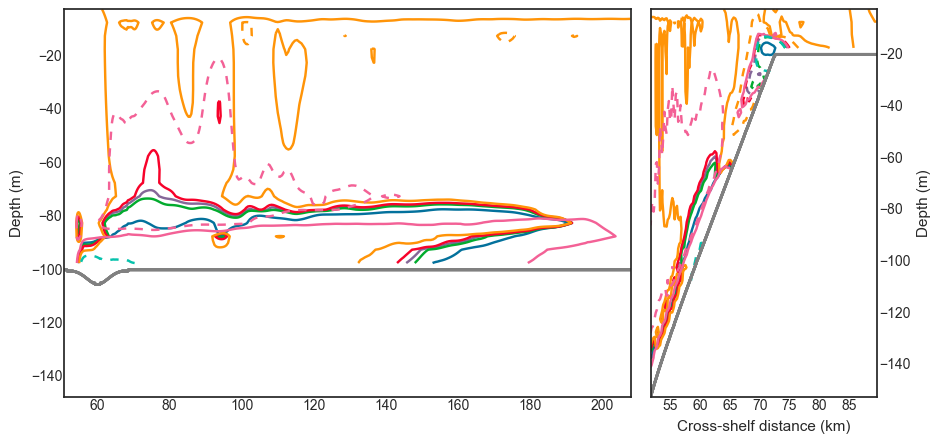

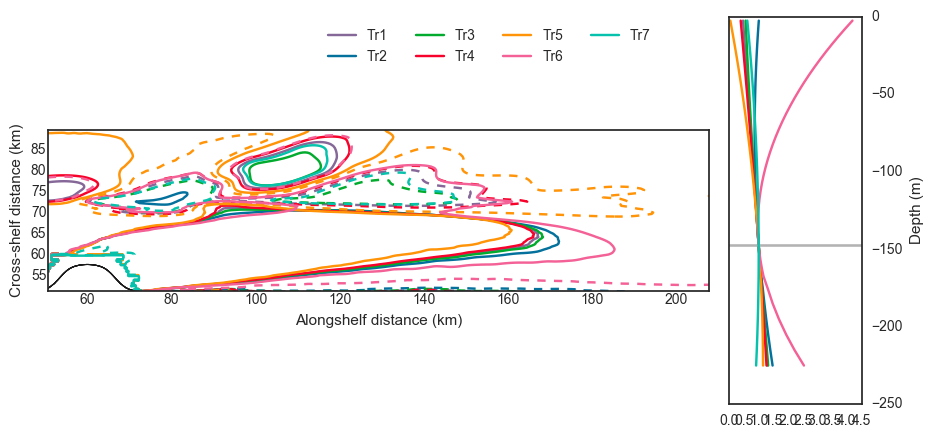

In [20]:
f = plt.figure(figsize = (10.5,5.0)) # 19.0cm = 7.4in, 115cm = 4.52in

gs = gspec.GridSpec(1, 2, width_ratios=[1,0.4], wspace=0.05, hspace=0.05 )

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

f1 = plt.figure(figsize = (10.5,5.0)) # 19.0cm = 7.4in, 115cm = 4.52in

gs2 = gspec.GridSpec(1, 2,  width_ratios=[1,0.2], wspace=0.05, hspace=0.05 )

ax2 = plt.subplot(gs2[0])
ax3 = plt.subplot(gs2[1])

ii = 0    

PlotPool(ax2,(ConcFilt1Anom[:,:])/Conc0Filt1,xslice,yslice,col=sns.xkcd_rgb[colours[0]])
PlotPool(ax2,(ConcFilt2Anom[:,:])/Conc0Filt2,xslice,yslice,col=sns.xkcd_rgb[colours[1]])
PlotPool(ax2,(ConcFilt3Anom[:,:])/Conc0Filt3,xslice,yslice,col=sns.xkcd_rgb[colours[2]])
PlotPool(ax2,(ConcFilt4Anom[:,:])/Conc0Filt4,xslice,yslice,col=sns.xkcd_rgb[colours[3]])
PlotPool(ax2,(ConcFilt5Anom[:,:])/Conc0Filt5,xslice,yslice,col=sns.xkcd_rgb[colours[4]])
PlotPool(ax2,(ConcFilt6Anom[:,:])/Conc0Filt6,xslice,yslice,col=sns.xkcd_rgb[colours[5]])
PlotPool(ax2,(ConcFilt7Anom[:,:])/Conc0Filt7,xslice,yslice,col=sns.xkcd_rgb[colours[6]])

PlotAS(ax0,(ConcAS1Anom[:,:]/Conc0AS1),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[0]])
PlotAS(ax0,(ConcAS2Anom[:,:]/Conc0AS2),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[1]])
PlotAS(ax0,(ConcAS3Anom[:,:]/Conc0AS3),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[2]])
PlotAS(ax0,(ConcAS4Anom[:,:]/Conc0AS4),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[3]])
PlotAS(ax0,(ConcAS5Anom[:,:]/Conc0AS5),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[4]])
PlotAS(ax0,(ConcAS6Anom[:,:]/Conc0AS6),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[5]])
PlotAS(ax0,(ConcAS7Anom[:,:]/Conc0AS7),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[6]])
 
PlotCS(ax1,(ConcCS1Anom[:,:]/Conc0CS1[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[0]])
PlotCS(ax1,(ConcCS2Anom[:,:]/Conc0CS2[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[1]])
PlotCS(ax1,(ConcCS3Anom[:,:]/Conc0CS3[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[2]])
PlotCS(ax1,(ConcCS4Anom[:,:]/Conc0CS4[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[3]])
PlotCS(ax1,(ConcCS5Anom[:,:]/Conc0CS5[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[4]])
PlotCS(ax1,(ConcCS6Anom[:,:]/Conc0CS6[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[5]])
PlotCS(ax1,(ConcCS7Anom[:,:]/Conc0CS7[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[6]])

tracer_legend = ['Tr1','Tr2','Tr3','Tr4','Tr5','Tr6','Tr7']
with Dataset(ptracers_file, 'r') as nbl:
    for trac, ii, lab in zip(tracer_names, range(len(tracer_names)), tracer_legend):
        ax3.axhline(Z[29], color='0.7', linewidth=1)
        profile = nbl.variables[trac][0,0:40,50,180]
        C0 = profile[29]
        ax3.plot(profile/C0,Z[0:40],color=sns.xkcd_rgb[colours[ii]], label=lab)
        ax3.yaxis.tick_right()
        ax3.yaxis.set_label_position("right")
        ax3.set_ylabel('Depth (m)')

ax0.set_ylabel('Depth (m)')
ax2.set_xlabel('Alongshelf distance (km)')
ax2.set_ylabel('Cross-shelf distance (km)')
ax1.set_xlabel('Cross-shelf distance (km)')
ax1.set_ylabel('Depth (m)')

ax3.legend(ncol=4, bbox_to_anchor=(-0.5,1) )


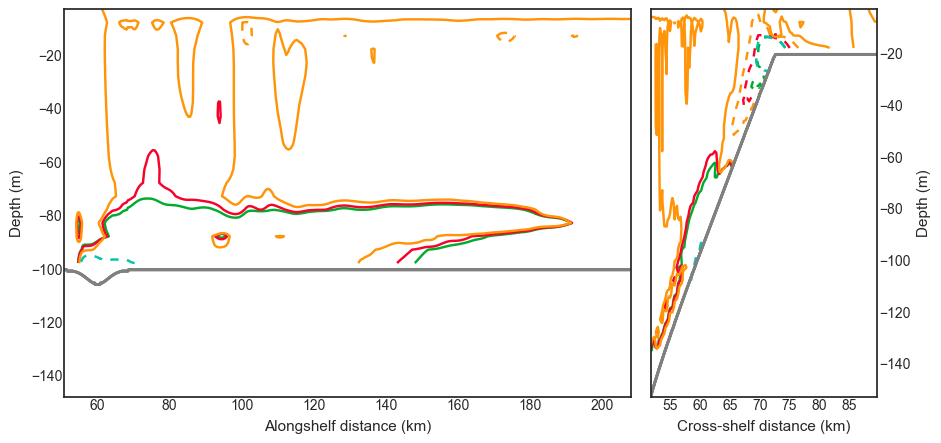

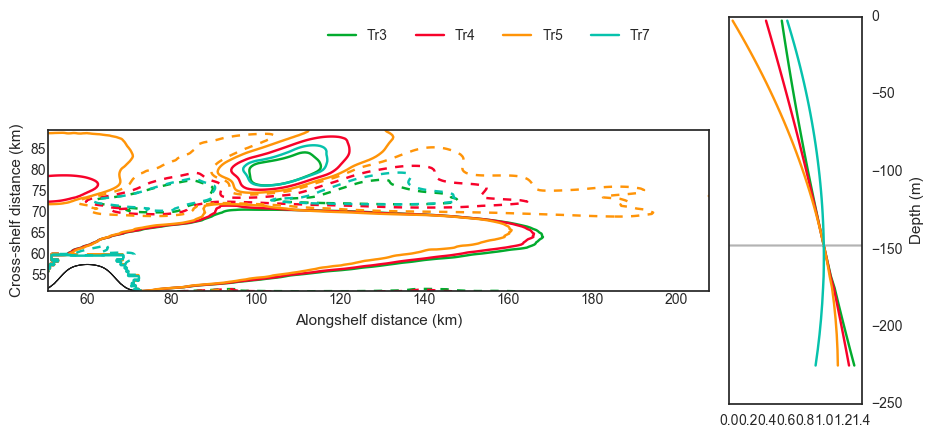

In [23]:
f1 = plt.figure(figsize = (10.5,5)) # 19.0cm = 7.4in, 115cm = 4.52in

gs = gspec.GridSpec(1, 2, width_ratios=[1,0.4], wspace=0.05, hspace=0.05 )

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

f1 = plt.figure(figsize = (10.5,5.0)) # 19.0cm = 7.4in, 115cm = 4.52in

gs2 = gspec.GridSpec(1, 2,  width_ratios=[1,0.2], wspace=0.05, hspace=0.05 )

ax2 = plt.subplot(gs2[0])
ax3 = plt.subplot(gs2[1])

ii = 0    

PlotPool(ax2,(ConcFilt3Anom[:,:])/Conc0Filt3,xslice,yslice,col=sns.xkcd_rgb[colours[2]])
PlotPool(ax2,(ConcFilt4Anom[:,:])/Conc0Filt4,xslice,yslice,col=sns.xkcd_rgb[colours[3]])
PlotPool(ax2,(ConcFilt5Anom[:,:])/Conc0Filt5,xslice,yslice,col=sns.xkcd_rgb[colours[4]])
PlotPool(ax2,(ConcFilt7Anom[:,:])/Conc0Filt7,xslice,yslice,col=sns.xkcd_rgb[colours[6]])

PlotAS(ax0,(ConcAS3Anom[:,:]/Conc0AS3),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[2]])
PlotAS(ax0,(ConcAS4Anom[:,:]/Conc0AS4),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[3]])
PlotAS(ax0,(ConcAS5Anom[:,:]/Conc0AS5),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[4]])
PlotAS(ax0,(ConcAS7Anom[:,:]/Conc0AS7),xslice_AS,zslice_AS,col=sns.xkcd_rgb[colours[6]])
 
PlotCS(ax1,(ConcCS3Anom[:,:]/Conc0CS3[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[2]])
PlotCS(ax1,(ConcCS4Anom[:,:]/Conc0CS4[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[3]])
PlotCS(ax1,(ConcCS5Anom[:,:]/Conc0CS5[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[4]])
PlotCS(ax1,(ConcCS7Anom[:,:]/Conc0CS7[:,:]),yslice_CS,zslice_AS,col=sns.xkcd_rgb[colours[6]])

tracer_names_2 = ['Tr3', 'Tr4', 'Tr5', 'Tr7']
tracer_legend_2 = ['Tr3', 'Tr4', 'Tr5', 'Tr7']

with Dataset(ptracers_file, 'r') as nbl:
    for trac, ii, lab in zip(tracer_names_2, [2,3,4,6], tracer_legend_2):
        ax3.axhline(Z[29], color='0.7', linewidth=1)
        profile = nbl.variables[trac][0,0:40,50,180]
        C0 = profile[29]
        ax3.plot(profile/C0,Z[0:40],color=sns.xkcd_rgb[colours[ii]], label=lab)
        ax3.yaxis.tick_right()
        ax3.yaxis.set_label_position("right")
        ax3.set_ylabel('Depth (m)')

ax0.set_ylabel('Depth (m)')
ax2.set_xlabel('Alongshelf distance (km)')
ax0.set_xlabel('Alongshelf distance (km)')

ax2.set_ylabel('Cross-shelf distance (km)')
ax1.set_xlabel('Cross-shelf distance (km)')
ax1.set_ylabel('Depth (m)')

ax3.legend(ncol=4, bbox_to_anchor=(-0.5,1) )

